![title](images/project_image.png)


[CrowdFlower](https://www.crowdflower.com/data-for-everyone/)

In [1]:
reset -fs

In [2]:
import pandas as pd
from collections import Counter,defaultdict
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbs
import re
from nltk.corpus import stopwords
from sklearn.decomposition import NMF
import lda
from sklearn.feature_extraction.text import CountVectorizer
from IPython.core.display import HTML
from nltk import word_tokenize
from operator import itemgetter
import string
%matplotlib inline

HTML("<style>.container { width:95% !important; }</style>")

In [3]:
#DISABLES AUTOSCROLL

# from IPython.display import display, Javascript
# disable_js = """
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }
# """

# def load_ipython_extension(ip):
#     display(Javascript(disable_js))
#     print ("autoscrolling long output is disabled")

### Load dataframe 

In [4]:
df = pd.read_csv('data/chemicals-and-disease-DFE.csv', encoding='latin-1', na_values=['?'])
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,comment_box,verify_relationship,verify_relationship:confidence,orig__golden,chemical_id,...,disease_id,disease_name,form_sentence,original_job_id,pmid,relation_pair_id,sentence_id,uniq_id,verify_relationship_gold,verify_relationship_gold_reason
0,770955372,True,golden,9,NaN,\n\n'5-HT6 receptors' and not just '5-HT'\n\n\...,yes_direct,0.4463,True,D012701,...,D011605,"<span class=""disease"">psychotic disorders</span>",These animal models were considered to reflect...,762850.0,20705401,20705401_D012701_D011605,20705401_4,bcv_easy_68_sent_dev_set_762850,no_relation,The receptors to 5-HT6 are related to psychoti...
1,770955373,True,golden,11,NaN,\n\n\n\n\n\n\n\n\n\n,no_relation,0.9181,True,D010396,...,D012594,"<span class=""disease"">localized scleroderma</s...","Case reports of 11 patients with severe, exten...",762850.0,2334179,2334179_D010396_D012594,2334179_3,bcv_easy_2399_sent_dev_set_762850,no_relation,D-penicillamine was used to treat the patients.
2,770955374,True,golden,12,NaN,\n\n\n\n\n\n\n\n\n\n\n,no_relation,1.0000,True,D015016,...,D019964,"<span class=""disease"">affective disorders</span>",METHOD: Six patients with either obsessive com...,762850.0,1535072,1535072_D015016_D019964,1535072_4,bcv_easy_642_sent_dev_set_762850,no_relation,The sentence says the affective disorders were...
3,770955375,True,golden,11,NaN,\n\n\n\n\n\n\n\n\n\n,no_relation,1.0000,True,D002118,...,D013035,"<span class=""disease"">muscle spasms</span>",While severe hypokalemia may cause muscle weak...,762850.0,8492347,8492347_D002118_D013035,8492347_2,bcv_easy_1271_sent_dev_set_762850,no_relation,The sentence says calcium supplementation cann...
4,770955376,True,golden,9,NaN,\n\n\n\n\n\n\n\n,no_relation,0.8905,True,D064730,...,D006402,"<span class=""disease"">hematologic toxicity</span>",Clinical trials in patients with brain metasta...,762850.0,15897593,15897593_D064730_D006402,15897593_8,bcv_easy_2793_sent_dev_set_762850,no_relation,Dexrazoxane is being used to try and make the ...


In [5]:
df.shape

(5713, 21)

In [6]:
#remove underscores from the beginning of column names 
df.columns = ['unit_id', 'golden', 'unit_state', 'trusted_judgments',
       'last_judgment_at', 'comment_box', 'verify_relationship',
       'verify_relationship:confidence', 'orig__golden', 'chemical_id',
       'chemical_name', 'disease_id', 'disease_name', 'form_sentence',
       'original_job_id', 'pmid', 'relation_pair_id', 'sentence_id', 'uniq_id',
       'verify_relationship_gold', 'verify_relationship_gold_reason']

In [7]:
df.verify_relationship.value_counts() #we will use this column to determine relationship between chemical and disease

no_relation     4722
yes_direct       980
yes_indirect      11
Name: verify_relationship, dtype: int64

In [8]:
df.verify_relationship_gold.value_counts() #there are much fewer of these counts than the above column. 

no_relation     284
yes_direct      266
yes_indirect      3
Name: verify_relationship_gold, dtype: int64

In [9]:
column_meanings = {
    'unit_id':'id of specific row',
    'golden':'Boolean showing which state of judgement it is in. Finalized or Golden.',
    'unit_state': "{finalized, golden}.",
    'trusted_judgments': 'how many people judged the comment to be either True or False',
    'last_judgment_at': 'day and time of when the last judgement was made',
    'comment_box':'comments from the judges',
    'verify_relationship':"{no_relation, yes_direct, yes_indirect}. Judgement on relationship of chemical to disease",
    'verify_relationship:confidence': 'score of confidence of relationship between 0 and 1',
    'orig__golden':'original boolean determining if the chemical does cause the disease. Only 551:5162 are the same',
    'chemical_id': 'ID of chemical. D######',
    'chemical_name': 'name of chemical',
    'disease_id': 'ID of disease. D######',
    'disease_name': 'name of disease',
    'form_sentence': 'summary of article represented in that row',
    'original_job_id': 'ID of job',
    'pmid': 'unique ID used in PubMed. They are assigned to each article record when it enters the PubMed system',
    'relation_pair_id': 'ID of relation pair',
    'sentence_id': 'ID of sentence',
    'uniq_id': 'ID of unique',
    'verify_relationship_gold': '{yes_indirect,nan,yes_direct,no_relation} determining if there is a relationship',
    'verify_relationship_gold_reason':'explanation for why they chose that reasoning'
}

In [10]:
print("chemical and disease: ", df.chemical_name[0], df.disease_name[0])
print("comment box: ", df.comment_box[0])
print("form sentence: ", df.form_sentence[0],end='\n\n')
print("verify relationship gold reason: ", df.verify_relationship_gold_reason[0],end='\n\n')
print("verify relationship: ", df.verify_relationship[0])

chemical and disease:  <span class="chemical">5-HT</span> <span class="disease">psychotic disorders</span>
comment box:  

'5-HT6 receptors' and not just '5-HT'






form sentence:  These animal models were considered to reflect the positive symptoms of schizophrenia, and the above evidence suggests that altered <span class="chemical">5-HT</span>6 receptors are involved in the pathophysiology of <span class="disease">psychotic disorders</span>.

verify relationship gold reason:  The receptors to 5-HT6 are related to psychotic disorders, not 5-HT itself.

verify relationship:  yes_direct


Even though there is the word "not" in the verify relationship gold reason, it is labeled as a direct relationship.

### Data cleaning

In [11]:
#remove unnecessary labels
df1 = df.drop(['unit_id','golden','unit_state','trusted_judgments','last_judgment_at',
               'verify_relationship:confidence','orig__golden','chemical_id','disease_id','original_job_id',
               'relation_pair_id','sentence_id','uniq_id','verify_relationship_gold'], axis=1).copy()

In [12]:
#cleaning comment box: 
cleaned_comment_box = []
for s in df1.comment_box: 
    s_cleaned = re.sub("\\n","", str(s)).replace("'","")
    cleaned_comment_box.append(s_cleaned)
df1.comment_box = cleaned_comment_box

In [13]:
df1.comment_box[0]

'5-HT6 receptors and not just 5-HT'

In [14]:
#cleaning chemical and disease names
def span_to_words( raw_span ):
    return BeautifulSoup(raw_span, "lxml").get_text() 

clean_chemical_name = []
clean_disease_name = []
for i in range(0, df1.shape[0]):
    clean_chemical_name.append( span_to_words( df1["chemical_name"][i] ) )
    clean_disease_name.append( span_to_words( df1["disease_name"][i] ) )
df1.chemical_name = clean_chemical_name
df1.disease_name = clean_disease_name

In [15]:
cleaned_names = clean_chemical_name + clean_disease_name

In [16]:
def review_to_words( raw_review ):
    #Remove HTML
    raw_review = raw_review.replace(">","> ")
    review_text = BeautifulSoup(raw_review, "lxml").get_text().split()
    
    #if word is not a disease or chemical, remove non-alpha. else, retain word. 
    cleaned_sentence = []
    for word in review_text:
        if word not in cleaned_names:
            cleaned_sentence.append(re.sub("[^a-zA-Z]", "", word.lower()))
        else:
            cleaned_sentence.append(word.lower())
    
    #remove stops, extra spaces, and single-letter words 
    stops = set(stopwords.words("english"))  
    spaces = set(" ")
    single_letter_words = set(string.ascii_lowercase)
    unimportant_words = stops | spaces | single_letter_words
    
    return (" ".join([word for word in cleaned_sentence if not word in list(unimportant_words)])).replace("  "," ")


In [17]:
df1.form_sentence[0]

'These animal models were considered to reflect the positive symptoms of schizophrenia, and the above evidence suggests that altered <span class="chemical">5-HT</span>6 receptors are involved in the pathophysiology of <span class="disease">psychotic disorders</span>.'

In [18]:
review_to_words(df1.form_sentence[0])

'animal models considered reflect positive symptoms schizophrenia evidence suggests altered 5-ht receptors involved pathophysiology psychotic disorders '

In [19]:
# Cleaning comment_box, form_sentence, and verify_relationship_gold_reason
clean_form_sentence = []
clean_verify_relationship_gold_reason = []
clean_comment_box = []

for i in range( 0, df1.shape[0] ):
    clean_form_sentence.append( review_to_words( df1["form_sentence"][i] ) )
    clean_verify_relationship_gold_reason.append( review_to_words( str(df1["verify_relationship_gold_reason"][i])) )
    clean_comment_box.append( review_to_words( df1["comment_box"][i] ) )


In [20]:
df1.form_sentence = clean_form_sentence 
df1.verify_relationship_gold_reason = clean_verify_relationship_gold_reason
df1.comment_box = clean_comment_box

In [21]:
#merge all wordy columns into 1 column: relationship_info
df1['relationship_info'] = (df1["form_sentence"].map(str) + df1["verify_relationship_gold_reason"] + df1["comment_box"])

df1.relationship_info[0]

'animal models considered reflect positive symptoms schizophrenia evidence suggests altered 5-ht receptors involved pathophysiology psychotic disorders receptors ht related psychotic disorders 5-htht receptors 5-ht'

In [22]:
df2 = df1.drop(['comment_box','form_sentence','verify_relationship_gold_reason'], axis=1).copy()
df2.head()

,verify_relationship,chemical_name,disease_name,pmid,relationship_info
0,yes_direct,5-HT,psychotic disorders,20705401,animal models considered reflect positive symp...
1,no_relation,D-penicillamine,localized scleroderma,2334179,case reports patients severe extensive localiz...
2,no_relation,yohimbine,affective disorders,1535072,method six patients either obsessive compulsiv...
3,no_relation,calcium,muscle spasms,8492347,severe hypokalemia may cause muscle weakness s...
4,no_relation,dexrazoxane,hematologic toxicity,15897593,clinical trials patients brain metastases comb...


In [23]:
df2.shape

(5713, 5)

In [24]:
#visualizing the data: there are a lot less yes_relations than no_relations. 
df2.verify_relationship.value_counts()

no_relation     4722
yes_direct       980
yes_indirect      11
Name: verify_relationship, dtype: int64

The model is currently overfit because the model is excessively complex... It has too many parameters relative to the number of observations. We will merge the "yes's" in the following section.

### Class Imbalance
#### Remove chemicals/diseases that only occur once and are in the same row.

In [25]:
#How many chemicals are only mentioned once?
print("# of chemicals occuring once: ", sum( x == 1 for x in Counter(df2.chemical_name).values() ))

#How many diseases are only mentioned once?
print("# of diseases occuring once: ", sum( x == 1 for x in Counter(df2.disease_name).values() ))

# of chemicals occuring once:  608
# of diseases occuring once:  877


In [26]:
#append the diseases that only occur once in a list
disease_dict = Counter(df2.disease_name)
disease_names_occuring_once = []
for k,v in disease_dict.items():
    if v == 1:
        disease_names_occuring_once.append(k)

#append the chemicals that only occur once in a list
chemical_dict = Counter(df2.chemical_name)
chemical_names_occuring_once = []
for k,v in chemical_dict.items():
    if v == 1:
        chemical_names_occuring_once.append(k)

In [27]:
#How many chemicals that occur only once, cause a disease that occurs only once? 
chemicals_and_diseases_occuring_once = []
for c,d in zip(df2.chemical_name, df2.disease_name):
    if c in chemical_names_occuring_once and d in disease_names_occuring_once:
        chemicals_and_diseases_occuring_once.append((c,d))
len(chemicals_and_diseases_occuring_once)

115

In [28]:
#removing above chemicals and diseases that only occur once from df2 and creating df3
mask = df2['chemical_name'].isin(c for c,d in chemicals_and_diseases_occuring_once)
df3 = df2[~mask].copy()

In [29]:
#boolean verify_relationship (merging yes_direct and yes_indirect to simplify our graph)
temp = {'yes_direct': True, 'yes_indirect':True, 'no_relation':False}
df3['boolean_relationship'] = df3['verify_relationship'].map(temp)
df4 = df3.drop(['verify_relationship'], axis=1).copy()

In [30]:
print(df4.shape)
df4.head()

(5598, 5)


,chemical_name,disease_name,pmid,relationship_info,boolean_relationship
0,5-HT,psychotic disorders,20705401,animal models considered reflect positive symp...,True
1,D-penicillamine,localized scleroderma,2334179,case reports patients severe extensive localiz...,False
2,yohimbine,affective disorders,1535072,method six patients either obsessive compulsiv...,False
3,calcium,muscle spasms,8492347,severe hypokalemia may cause muscle weakness s...,False
4,dexrazoxane,hematologic toxicity,15897593,clinical trials patients brain metastases comb...,False


In [31]:
df4.boolean_relationship.value_counts()

False    4634
True      964
Name: boolean_relationship, dtype: int64

#### Randomly sample 964 Falses

In [32]:
df_true = df4[df4['boolean_relationship']==True]
df_false0 = df4[df4['boolean_relationship']==False]

In [33]:
df_true.shape

(964, 5)

In [34]:
df_false = df_false0.sample(n=df3.boolean_relationship.value_counts()[1], random_state=1).reset_index(drop=True)
df_false.shape

(964, 5)

### Final dataframe

In [35]:
#final dataframe is of the columns I wish to vectorize.
df_labeled = df_true[['boolean_relationship','relationship_info','pmid','chemical_name','disease_name']].append(df_false[['boolean_relationship','relationship_info','pmid','chemical_name','disease_name']])

#shuffling the rows... 
df_labeled = df_labeled.sample(frac=1, random_state=1).reset_index(drop=True)
df_labeled.head()

,boolean_relationship,relationship_info,pmid,chemical_name,disease_name
0,True,describe yearold woman preexisting mitral valv...,11419773,caffeine,ventricular fibrillation
1,False,laxation critically ill patients lactulose pol...,17893628,lactulose,critically ill
2,False,methotrexate mtx sulfasalazine ssz cyclosporin...,12463452,sulfasalazine/SSZ,PsA
3,True,polychlorinated biphenyls pcbs persistent envi...,24812009,Polychlorinated biphenyls/PCBs,NAFLD/non-alcoholic fatty liver disease
4,True,although pcp classified human carcinogen epide...,7904464,PCP,sarcoma


In [36]:
df_labeled.shape

(1928, 5)

In [37]:
df_labeled.to_csv( "data/labeled_df.csv", index=False)

### Data Visualization

In [38]:
#visualize diseases based on whether they are true or false 
df_diseases0 = pd.DataFrame([df_true.disease_name.value_counts(), df_false.disease_name.value_counts()])
df_diseases = df_diseases0.transpose().copy()
df_diseases.columns = ["True","False"]
df_diseases.dropna(inplace=True)
df_diseases.head()

,True,False
AD/Alzheimer's disease,1.0,1.0
ADRP,2.0,1.0
AF,1.0,2.0
AML,1.0,1.0
ESRD,1.0,1.0


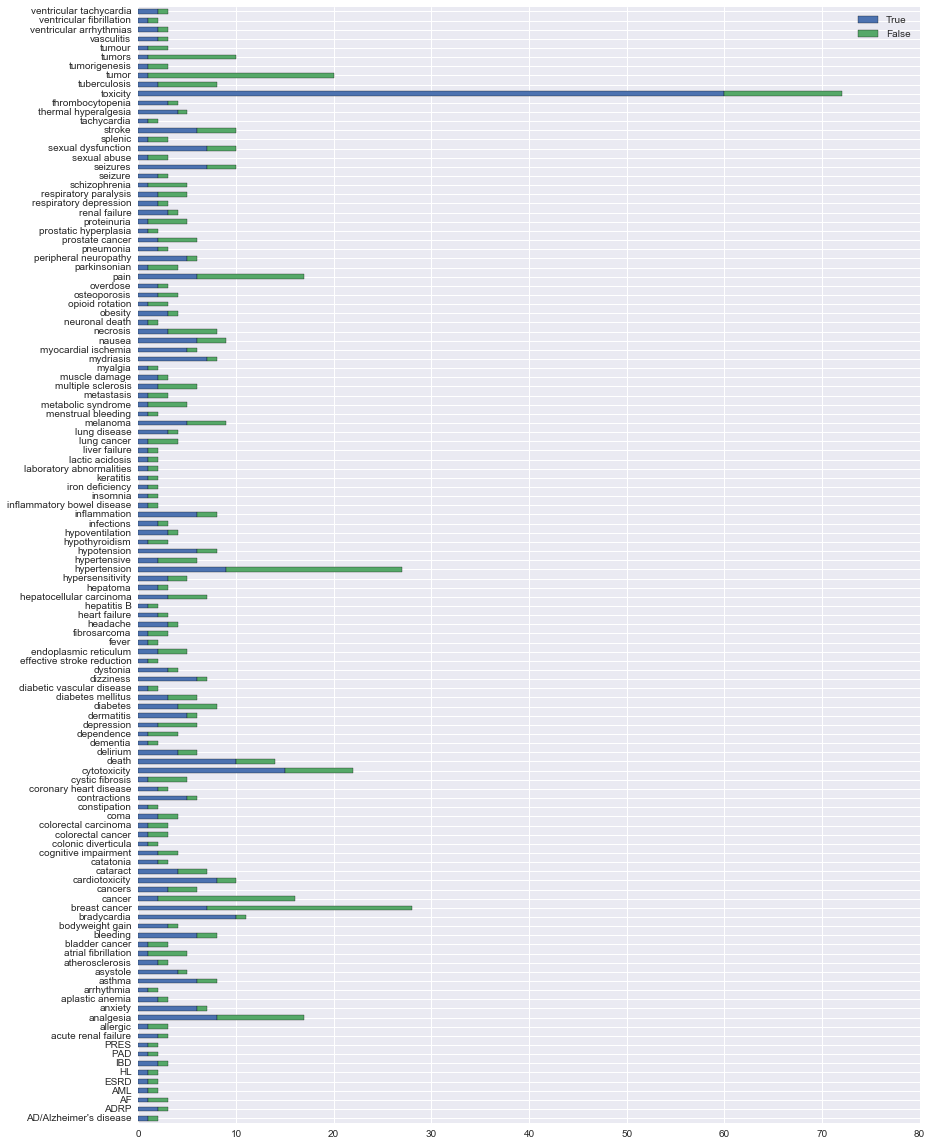

In [39]:
df_diseases.plot.barh(stacked=True,figsize=(14,20));

In [40]:
#visualize chemicals based on whether they are true or false 
df_chemicals = pd.DataFrame([df_true.chemical_name.value_counts(), df_false.chemical_name.value_counts()])
df_chemicals = df_chemicals.transpose().copy()
df_chemicals.dropna(inplace = True)
df_chemicals.columns = ["True","False"]
df_chemicals.head()

,True,False
5-FU,1.0,5.0
5-FU/5-fluorouracil,1.0,3.0
5-aza-2'-deoxycytidine,1.0,1.0
5-fluorouracil,4.0,2.0
ADR,4.0,1.0


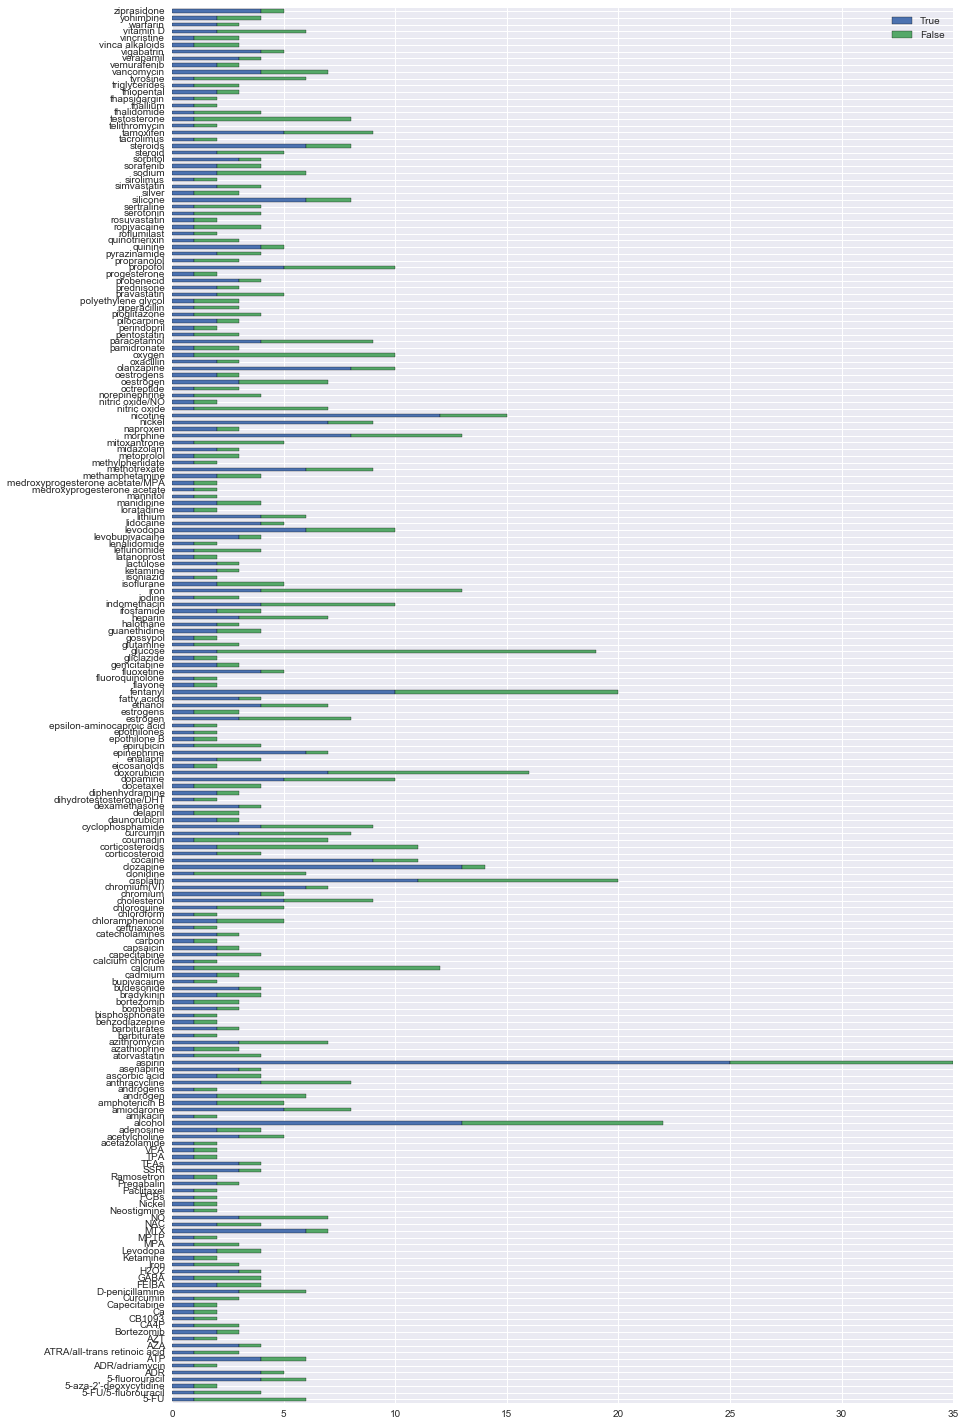

In [41]:
df_chemicals.plot.barh(stacked=True,figsize=(14,25));

** both disease and chemical datasets seem more balanced now. ** 

### Create vocabularies of True/False

In [42]:
#separate words into 2 lists, and count word frequency. 
true_vocab = ""
for doc in df_true.relationship_info:
    true_vocab += doc
print("length of true vocab: ", len(true_vocab.split()))

false_vocab = ""
for doc in df_false.relationship_info:
    false_vocab += doc
print("length of false vocab: ", len(false_vocab.split()))

length of true vocab:  14317
length of false vocab:  16273


### Tokenizing

In [46]:
from nltk.tokenize import wordpunct_tokenize
wordpunct_tokenize(true_vocab)[:20]
#I do not like this version, because it split up the chemical '5-HT' into 3 different tokens. 

['animal',
 'models',
 'considered',
 'reflect',
 'positive',
 'symptoms',
 'schizophrenia',
 'evidence',
 'suggests',
 'altered',
 '5',
 '-',
 'ht',
 'receptors',
 'involved',
 'pathophysiology',
 'psychotic',
 'disorders',
 'receptors',
 'ht']

#### Stemming

In [47]:
#stemming is the process for reducing words to their stem, base, or root form
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
true_stem = [porter_stemmer.stem(w) for w in true_vocab.split(' ')]
false_stem = [porter_stemmer.stem(w) for w in false_vocab.split(' ')]
true_stem[:20]
#It is understandable, but it breaks the words. 

['anim',
 'model',
 'consid',
 'reflect',
 'posit',
 'symptom',
 'schizophrenia',
 'evid',
 'suggest',
 'alter',
 '5-ht',
 'receptor',
 'involv',
 'pathophysiolog',
 'psychot',
 'disord',
 'receptor',
 'ht',
 'relat',
 'psychot']

#### Lemmatizing

In [48]:
#lemmatization is the process of grouping together the different forms of a word so they can be analysed as a single item.
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
true_lem = [wordnet_lemmatizer.lemmatize(w) for w in true_vocab.split(' ')]
false_lem = [wordnet_lemmatizer.lemmatize(w) for w in false_vocab.split(' ')]
true_lem[:20]

['animal',
 'model',
 'considered',
 'reflect',
 'positive',
 'symptom',
 'schizophrenia',
 'evidence',
 'suggests',
 'altered',
 '5-ht',
 'receptor',
 'involved',
 'pathophysiology',
 'psychotic',
 'disorder',
 'receptor',
 'ht',
 'related',
 'psychotic']

In [49]:
true_word_freq_stem = Counter(true_stem)
false_word_freq_stem = Counter(false_stem)

true_word_freq_stem.most_common(10)

[('patient', 173),
 ('associ', 163),
 ('induc', 157),
 ('increas', 127),
 ('', 124),
 ('toxic', 110),
 ('caus', 108),
 ('effect', 89),
 ('develop', 86),
 ('risk', 80)]

In [50]:
false_word_freq_stem.most_common(10)

[('patient', 285),
 ('effect', 164),
 ('treatment', 161),
 ('', 158),
 ('cell', 137),
 ('studi', 136),
 ('cancer', 123),
 ('use', 97),
 ('therapi', 94),
 ('diseas', 89)]

In [51]:
true_word_freq_lem = Counter(true_lem)
false_word_freq_lem = Counter(false_lem)

true_word_freq_lem.most_common(10)

[('patient', 173),
 ('associated', 152),
 ('induced', 136),
 ('', 124),
 ('toxicity', 98),
 ('increased', 95),
 ('risk', 80),
 ('effect', 74),
 ('treatment', 72),
 ('may', 69)]

In [52]:
false_word_freq_lem.most_common(10)

[('patient', 285),
 ('treatment', 161),
 ('', 158),
 ('cell', 137),
 ('cancer', 123),
 ('study', 122),
 ('effect', 112),
 ('therapy', 94),
 ('disease', 89),
 ('human', 62)]

### Summary
- Stemming is getting better results than lemmatizing, because it breaks up the words more. 
- No matter if the chemical causes the disease or not, 'patient' is the most frequent word.
- It would be interesting to see the different topics of the articles, but first let's get more words.